In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)

## Add

In [3]:
import random

def random_add_instance(length):
    a = [random.randint(0,9) for i in range(length)]
    b = [random.randint(0,9) for i in range(length)]
    val_a = int(''.join(str(d) for d in a))
    val_b = int(''.join(str(d) for d in b))
    val_c = val_a + val_b
    str_c = str(val_c)
    str_c = (length + 1 - len(str_c)) * '0' + str_c
    return a + b + [int(d) for d in str_c]

for i in range(10):
    print (random_add_instance(3))



[0, 6, 2, 5, 3, 6, 0, 5, 9, 8]
[4, 9, 5, 3, 7, 8, 0, 8, 7, 3]
[6, 4, 4, 3, 1, 4, 0, 9, 5, 8]
[3, 5, 9, 1, 1, 9, 0, 4, 7, 8]
[3, 5, 0, 1, 4, 8, 0, 4, 9, 8]
[0, 0, 2, 9, 3, 7, 0, 9, 3, 9]
[8, 4, 8, 2, 3, 7, 1, 0, 8, 5]
[9, 9, 9, 7, 0, 6, 1, 7, 0, 5]
[7, 4, 5, 1, 3, 6, 0, 8, 8, 1]
[1, 0, 1, 0, 4, 2, 0, 1, 4, 3]


In [4]:
class AddDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return 10
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 3 * self.length + 1 - 1

    def __getitem__(self, idx):
        while True:
            rai = random_add_instance(self.length)
            h = hash(str(rai[:2*self.length]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*self.length-1] = -1
        return x, y

In [6]:
# print an example instance of the dataset
train_dataset = AddDataset('train')
test_dataset = AddDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([2, 9, 3, 4, 8, 0, 0, 7, 7])
2 -1
9 -1
3 -1
4 -1
8 -1
0 0
0 7
7 7
7 3


In [243]:
# create a GPT instance
from mingpt.model import GPT

HEADS = 2
LAYERS = 1
EMBEDDING_DIM = 128

model_config = GPT.get_default_config()
model_config.model_type = None
# model_config.merge_from_dict({"model_type": None,
                            #   "n_heads": 4})
model_config.n_head = HEADS
model_config.n_layer = LAYERS
model_config.n_embd = EMBEDDING_DIM
print (model_config)
# model_config.model_type = 'gpt-nano'

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

model_type: None
n_layer: 2
n_head: 2
n_embd: 128
vocab_size: None
block_size: None
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 0.40M


In [244]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists(f'../weights/static/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth'):
    model.load_state_dict(torch.load(f'../weights/static/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth', map_location=device))
    print(model_config.n_heads, model_config.n_layers, model_config.n_embd)


In [247]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-7 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


In [248]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.18951
iter_dt 7.87ms; iter 100: train loss 0.12910
iter_dt 7.90ms; iter 200: train loss 0.13058
iter_dt 7.63ms; iter 300: train loss 0.12010
iter_dt 7.39ms; iter 400: train loss 0.15057
iter_dt 7.63ms; iter 500: train loss 0.11617
iter_dt 9.02ms; iter 600: train loss 0.16162
iter_dt 7.43ms; iter 700: train loss 0.14641
iter_dt 7.54ms; iter 800: train loss 0.15406
iter_dt 7.44ms; iter 900: train loss 0.15085
iter_dt 7.72ms; iter 1000: train loss 0.08653
iter_dt 7.71ms; iter 1100: train loss 0.18951
iter_dt 7.71ms; iter 1200: train loss 0.12852
iter_dt 7.45ms; iter 1300: train loss 0.11872
iter_dt 7.44ms; iter 1400: train loss 0.06612
iter_dt 7.60ms; iter 1500: train loss 0.09337
iter_dt 7.66ms; iter 1600: train loss 0.17283
iter_dt 7.85ms; iter 1700: train loss 0.17117
iter_dt 7.43ms; iter 1800: train loss 0.16916
iter_dt 7.46ms; iter 1900: train loss 0.15286
iter_dt 7.51ms; iter 2000: train loss 0.09991
iter_dt 7.66ms; iter 2100: train loss 0.15864


In [249]:
# now let's perform some evaluation
model.eval()
None

In [250]:
c_vals = []
w_vals = []

def eval_add_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    #loader = DataLoader(dataset, batch_size=1, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)

        inp = x[:, :2*n]
        sol = y[:, -n-1:]
        
        cat = model.generate(inp, n+1, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, -n-1:]         
        correct = (sol == sol_candidate).all(1).cpu() 
        incorrect = ~correct
        # print("Incorrect:", incorrect)
        c_vals.extend(sol[incorrect].tolist())
        w_vals.extend(sol_candidate[incorrect].tolist())
        # print(sol[incorrect].tolist())
        # mae = (sol[incorrect] - sol_candidate[incorrect])
        # print(mae.tolist())
        # errors.extend(mae.tolist())
        for i in range(x.size(0)):
            results.append(int(correct[i]))
    
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_add_split(trainer, 'train', max_batches=50)
    test_score  = eval_add_split(trainer, 'test',  max_batches=50)

train final score: 9522/10000 = 95.22% correct
test final score: 9562/10000 = 95.62% correct


In [251]:
errors = []

for c, w in zip(c_vals, w_vals):
    a = int(''.join(str(d) for d in c))
    b = int(''.join(str(d) for d in w))
    # print(a, b)
    # print(abs(a-b))
    errors.append(abs(a-b))

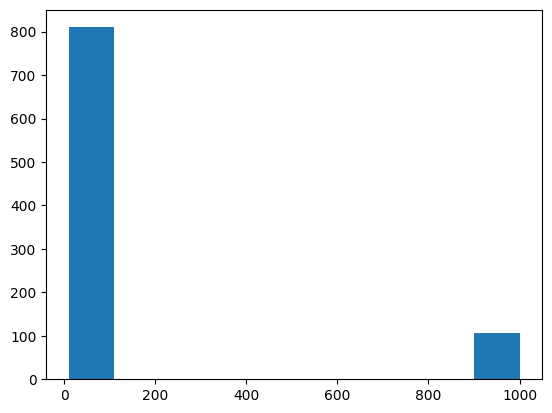

In [252]:
import matplotlib.pyplot as plt

# print (errors)

plt.hist(errors)
# plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.show()

In [253]:
torch.save(model.state_dict(), f'../weights/static/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth')